In [1]:
from langchain_text_splitters import (
    RecursiveCharacterTextSplitter,
)
from langchain.docstore.document import Document as LangchainDocument
from typing import Optional, List

import questllama.core.utils.file_utils as U
import questllama.core.utils.log_utils as L
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import pandas as pd
import matplotlib.pyplot as plt
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy

# Utility functions

In [2]:
def read_knowledge_database():
    action_files = U.read_skill_library("skill_library", full_path=True)
    return [
        LangchainDocument(page_content=doc[1], metadata={"source": doc[0]})
        for doc in action_files
    ]


# Read the skill library

In [3]:
RAW_KNOWLEDGE_BASE = read_knowledge_database()
i = 0
print(f"Read {len(RAW_KNOWLEDGE_BASE)} files")
print(f"============= Example {i} ========================")
print(f"source: {RAW_KNOWLEDGE_BASE[0].metadata['source']}")
print(f"content:{RAW_KNOWLEDGE_BASE[0].page_content}")

Read 311 files
============= Example 0 ========================
source: /home/atomwalk12/repos/QuestLlama/questllama/skill_library/trial6/skill/code/equipIronSword.js
content:async function equipIronSword(bot) {
  // Find the iron sword in the bot's inventory
  const ironSword = bot.inventory.findInventoryItem(mcData.itemsByName["iron_sword"].id);

  // Equip the iron sword in the main hand
  if (ironSword) {
    await bot.equip(ironSword, "hand");
    bot.chat("Iron sword equipped.");
  } else {
    bot.chat("No iron sword found in inventory.");
  }
}


# Encode the knowledge database.


In [4]:
JAVASCRIPT_SEPARATORS = [
    "\nfunction ",
    "\nconst ",
    "\nlet ",
    "\nvar ",
    "\nclass ",
    "\nif ",
    "\nfor ",
    "\nwhile ",
    "\nswitch ",
    "\ncase ",
    "\ndefault ",
    "\n\n",
    "\n",
    " ",
    "",
]
def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str],
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

    # FIXME: Is it necessary to pass the separators here? Try without them.
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        tokenizer,
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=JAVASCRIPT_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique, tokenizer


## Visualize a bar chart

Using encoder defined at flax-sentence-embeddings/st-codesearch-distilroberta-base.
Model's maximum sequence length: 128
Chunk size: 128.


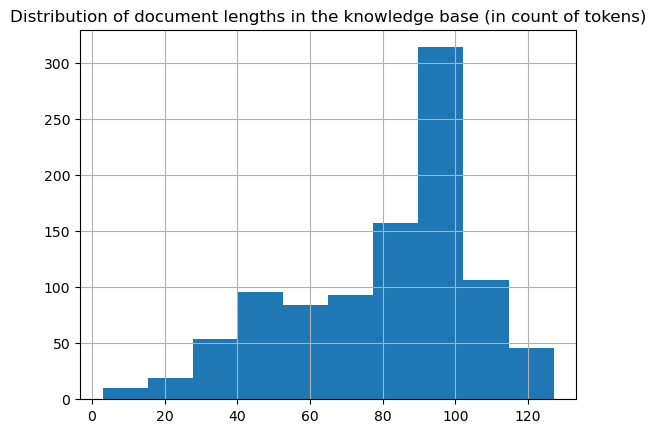

In [6]:
EMBEDDING_MODEL_NAME="flax-sentence-embeddings/st-codesearch-distilroberta-base"
CHUNK_SIZE = 128

print(f"Using encoder defined at {EMBEDDING_MODEL_NAME}.")
print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")
print(f"Chunk size: {CHUNK_SIZE}.")

docs_processed, tokenizer = split_documents(CHUNK_SIZE, RAW_KNOWLEDGE_BASE, EMBEDDING_MODEL_NAME)

lengths = [
    len(tokenizer.encode(doc.page_content)) for doc in docs_processed
]

fig = pd.Series(lengths).hist()
plt.title(
    "Distribution of document lengths in the knowledge base (in count of tokens)"
)
plt.show()

# Building and loading the vector database

In [7]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Visualize the knowledge database

In [7]:
# embed a user query in the same space
user_query = "// craft a furnace."
query_vector = embedding_model.embed_query(user_query)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# fit the data (The index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [9]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [10]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='// craft a furnace.'...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



==================================Top document==================================
// Craft a furnace using the cobblestones
  await craftItem(bot, "furnace", 1);
  bot.chat("Furnace crafted.");
}
==================================Metadata==================================
{'source': '/home/atomwalk12/repos/QuestLlama/questllama/skill_library/trial5/skill/code/craftFurnace.js', 'start_index': 741}


# Reader model

In [8]:
from transformers import pipeline
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from transformers import TextStreamer

READER_MODEL_NAME = "deepseek-ai/deepseek-coder-33b-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float32,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

streamer = TextStreamer(tokenizer)
READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    streamer=streamer,
    max_new_tokens=2048
)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Prompt template

In [9]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<｜begin▁of▁sentence｜>Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.### Instruction:
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
### Response:



# Reranking

In [10]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
from typing import Tuple
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

In [ ]:
question = "Mine 1 wood log."

answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

=> Retrieving documents...


ERROR:tornado.general:SEND Error: Host unreachable


KeyboardInterrupt: 

In [13]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)
    print(doc)

==================================Answer==================================
To kill 1 sheep, you can use the following code snippet:

```javascript
async function killOneSheep(bot) {
  // Kill the sheep
  await killMob(bot, "sheep");
  
  // Report the completion of the task
  bot.chat("1 sheep killed.");
}
```
This function will find and kill the nearest sheep within the bot's detection range. After killing the sheep, it will report the task completion.

==================================Source docs==================================
Document 0------------------------------------------------------------
// Kill each sheep one by one
  for (const singleSheep of sheep) {
    await killMob(bot, singleSheep.name, 300);
  }

  // Report the completion of the task
  bot.chat("3 sheep killed.");
}
// Kill each sheep one by one
  for (const singleSheep of sheep) {
    await killMob(bot, singleSheep.name, 300);
  }

  // Report the completion of the task
  bot.chat("3 sheep killed.");
}
Document